In [17]:
# common
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# output cell
from IPython.display import clear_output as cls

In [3]:
train_dir = '/kaggle/input/aksara-jawa/v3/v3/train/'
val_dir = '/kaggle/input/aksara-jawa/v3/v3/val/'

In [4]:
# Constants

IMAGE_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 10

LEARNING_RATE = 2e-5

LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

## Data Loading

In [5]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


### Augmentasi

In [6]:
pass

### Input Preprocessing Pipeline

- Rescaling
- Rescaling

In [7]:
def load_and_preprocess_image(image, label):    
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    return image, label

### Load with Tensor Datasets

In [8]:
# Create a dataset from the data directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
#     batch_size=BATCH_SIZE
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
#     batch_size=BATCH_SIZE
)

train_dataset = train_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

Found 2154 files belonging to 20 classes.
Found 480 files belonging to 20 classes.


### Data Distribution

In [9]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

### Data Visualization

In [24]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 1.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (10, 10).
    """
    images, labels = next(iter(dataset))
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Loop over the number of rows and columns
    for i in range(n_rows * n_cols):
        
        label = int(labels[i].numpy())
        title = "true: "+class_names[label]
        
        if model:
            pred = model.predict(images[i][np.newaxis])
            
            if check:
                if label == np.argmax(pred):
                    continue
            
            pred_label = f"Pred: {np.argmax(pred)}"
            pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
            if class_names:
                pred_label += f" ({class_names[np.argmax(pred)]})"
            title += f"\n{pred_label} {pred_percentage}"
            
        # Create a subplot for each image
        ax = fig.add_subplot(n_rows, n_cols, i+1)    
        
        # Plot the image
        ax.imshow(images[i].numpy().astype("uint8"))
        
        # Set the title to the corresponding label
        ax.set_title(title)
        
        # Remove the axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show the plot
    plt.show()

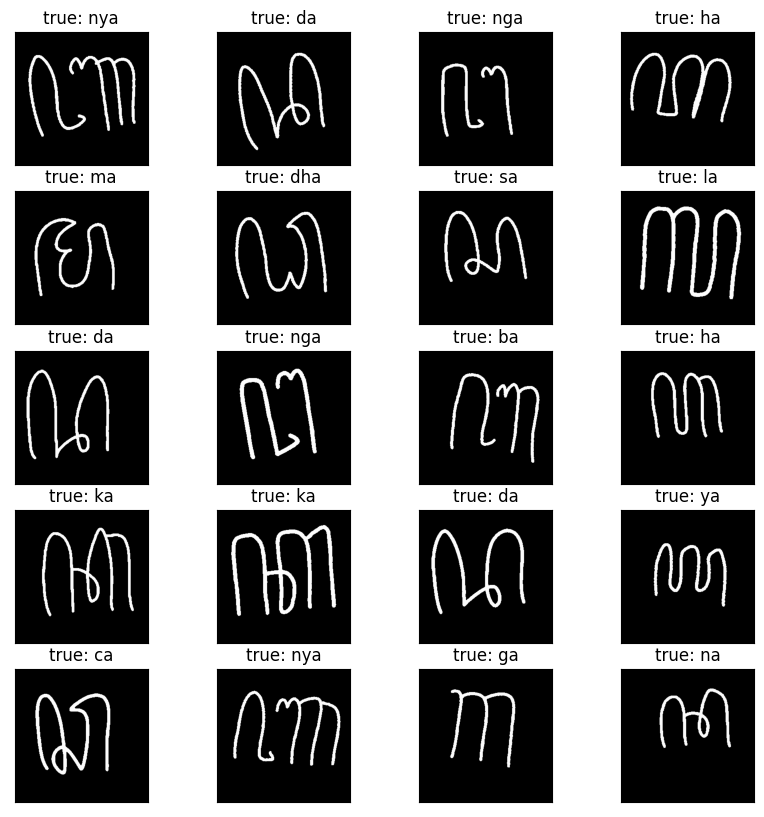

In [11]:
plot_images(train_dataset)

## Train and Fine Tuning

In [13]:
# Xception

xception = Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

# xception.trainable = False
xception.trainable = True


xception = Sequential([
    xception,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(n_classes, activation='softmax')
], name='aksara_jawa_xception_v1')

xception.compile(
    loss=LOSS,
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

print("\nTraining Xception Model: ")

# steps_per_epoch = len(X_train)
# STEPS_PER_EPOCH = 50


history = xception.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint("aksara_jawa_xception_v1_checkpoint.h5", save_best_only=True)
    ],
    batch_size=BATCH_SIZE,
#     steps_per_epoch=STEPS_PER_EPOCH
)


Training Xception Model: 
Epoch 1/10
68/68 [==============================] - 62s 539ms/step - loss: 2.6806 - accuracy: 0.2911 - val_loss: 2.8016 - val_accuracy: 0.2083
Epoch 2/10
68/68 [==============================] - 36s 519ms/step - loss: 1.6318 - accuracy: 0.8426 - val_loss: 2.0571 - val_accuracy: 0.5979
Epoch 3/10
68/68 [==============================] - 39s 555ms/step - loss: 0.8049 - accuracy: 0.9582 - val_loss: 1.2026 - val_accuracy: 0.7792
Epoch 4/10
68/68 [==============================] - 38s 555ms/step - loss: 0.3648 - accuracy: 0.9856 - val_loss: 0.7206 - val_accuracy: 0.8646
Epoch 5/10
68/68 [==============================] - 36s 517ms/step - loss: 0.1897 - accuracy: 0.9935 - val_loss: 0.4824 - val_accuracy: 0.8958
Epoch 6/10
68/68 [==============================] - 36s 517ms/step - loss: 0.1049 - accuracy: 0.9991 - val_loss: 0.3443 - val_accuracy: 0.9354
Epoch 7/10
68/68 [==============================] - 38s 554ms/step - loss: 0.0645 - accuracy: 1.0000 - val_loss: 0.

## Evaluate

In [26]:
# test_dir = '/kaggle/input/hanacaraka/'
test_dir = '/kaggle/input/javanese-script-aksara-jawa-augmented/test/'
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
)
test_dataset = train_dataset.map(load_and_preprocess_image)

Found 1200 files belonging to 20 classes.


In [27]:
test_loss, test_acc = xception.evaluate(test_dataset)
print("Loss    : {:.4}".format(test_loss))
print("Accuracy: {:.4}%".format(test_acc*100))

68/68 [==============================] - 12s 175ms/step - loss: 0.0121 - accuracy: 1.0000
Loss    : 0.01212
Accuracy: 100.0%


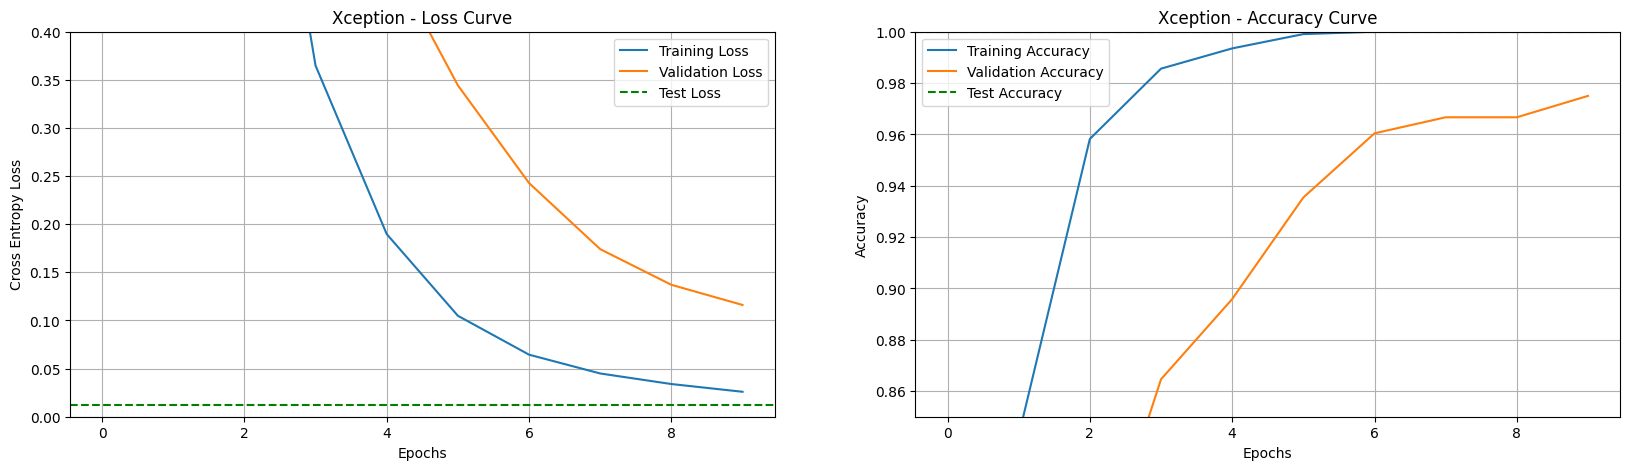

In [18]:
# Collect the history of the training run
history = pd.DataFrame(history.history)

# Create a figure to display the model's performance
plt.figure(figsize=(20, 5))

# Plot the loss curve in the first subplot
plt.subplot(1, 2, 1)
plt.title("Xception - Loss Curve")
plt.plot(history['loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")

# Horizontal line to show the testing performance
plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.ylim([0, 0.4])

# Show the legend and grid
plt.legend()
plt.grid()

# Plot the accuracy curve in the second subplot
plt.subplot(1, 2, 2)
plt.title("Xception - Accuracy Curve")
plt.plot(history['accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")

# Horizontal line to show the testing performance
plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

# Set the x- and y-labels, and the x- and y-limits
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0.85, 1])

# Show the legend and grid
plt.legend()
plt.grid()

# Display the plot
plt.show()

## F1-Score

In [ ]:
# # Make predictions
# baseline_pred = np.argmax(xception.predict(X_test, verbose=0), axis=-1)
# # best_pred = np.argmax(mobile_net_model.predict(X_test, verbose=0), axis=-1)

# # Evaluate prediction : Precision
# baseline_pre = precision_score(y_test, baseline_pred, average='macro', zero_division=0)
# # best_pre = precision_score(y_test, best_pred, average='macro')

# # Evaluate prediction : Recall
# baseline_recall = recall_score(y_test, baseline_pred, average='macro', zero_division=0)
# # best_recall = recall_score(y_test, best_pred, average='macro')

# # Evaluate prediction : F1 Score
# baseline_f1 = f1_score(y_test, baseline_pred, average='macro', zero_division=0)
# # best_f1 = f1_score(y_test, best_pred, average='macro')

# print("{:20}".format("Baseline Performance"))
# print("{:10} : {:.5}".format("Precision", baseline_pre))
# print("{:10} : {:.5}".format("Recall", baseline_recall))
# print("{:10} : {:.5}".format("F1 Score", baseline_f1))

## Output Prediction

1/1 [==============================] - 0s 25ms/step


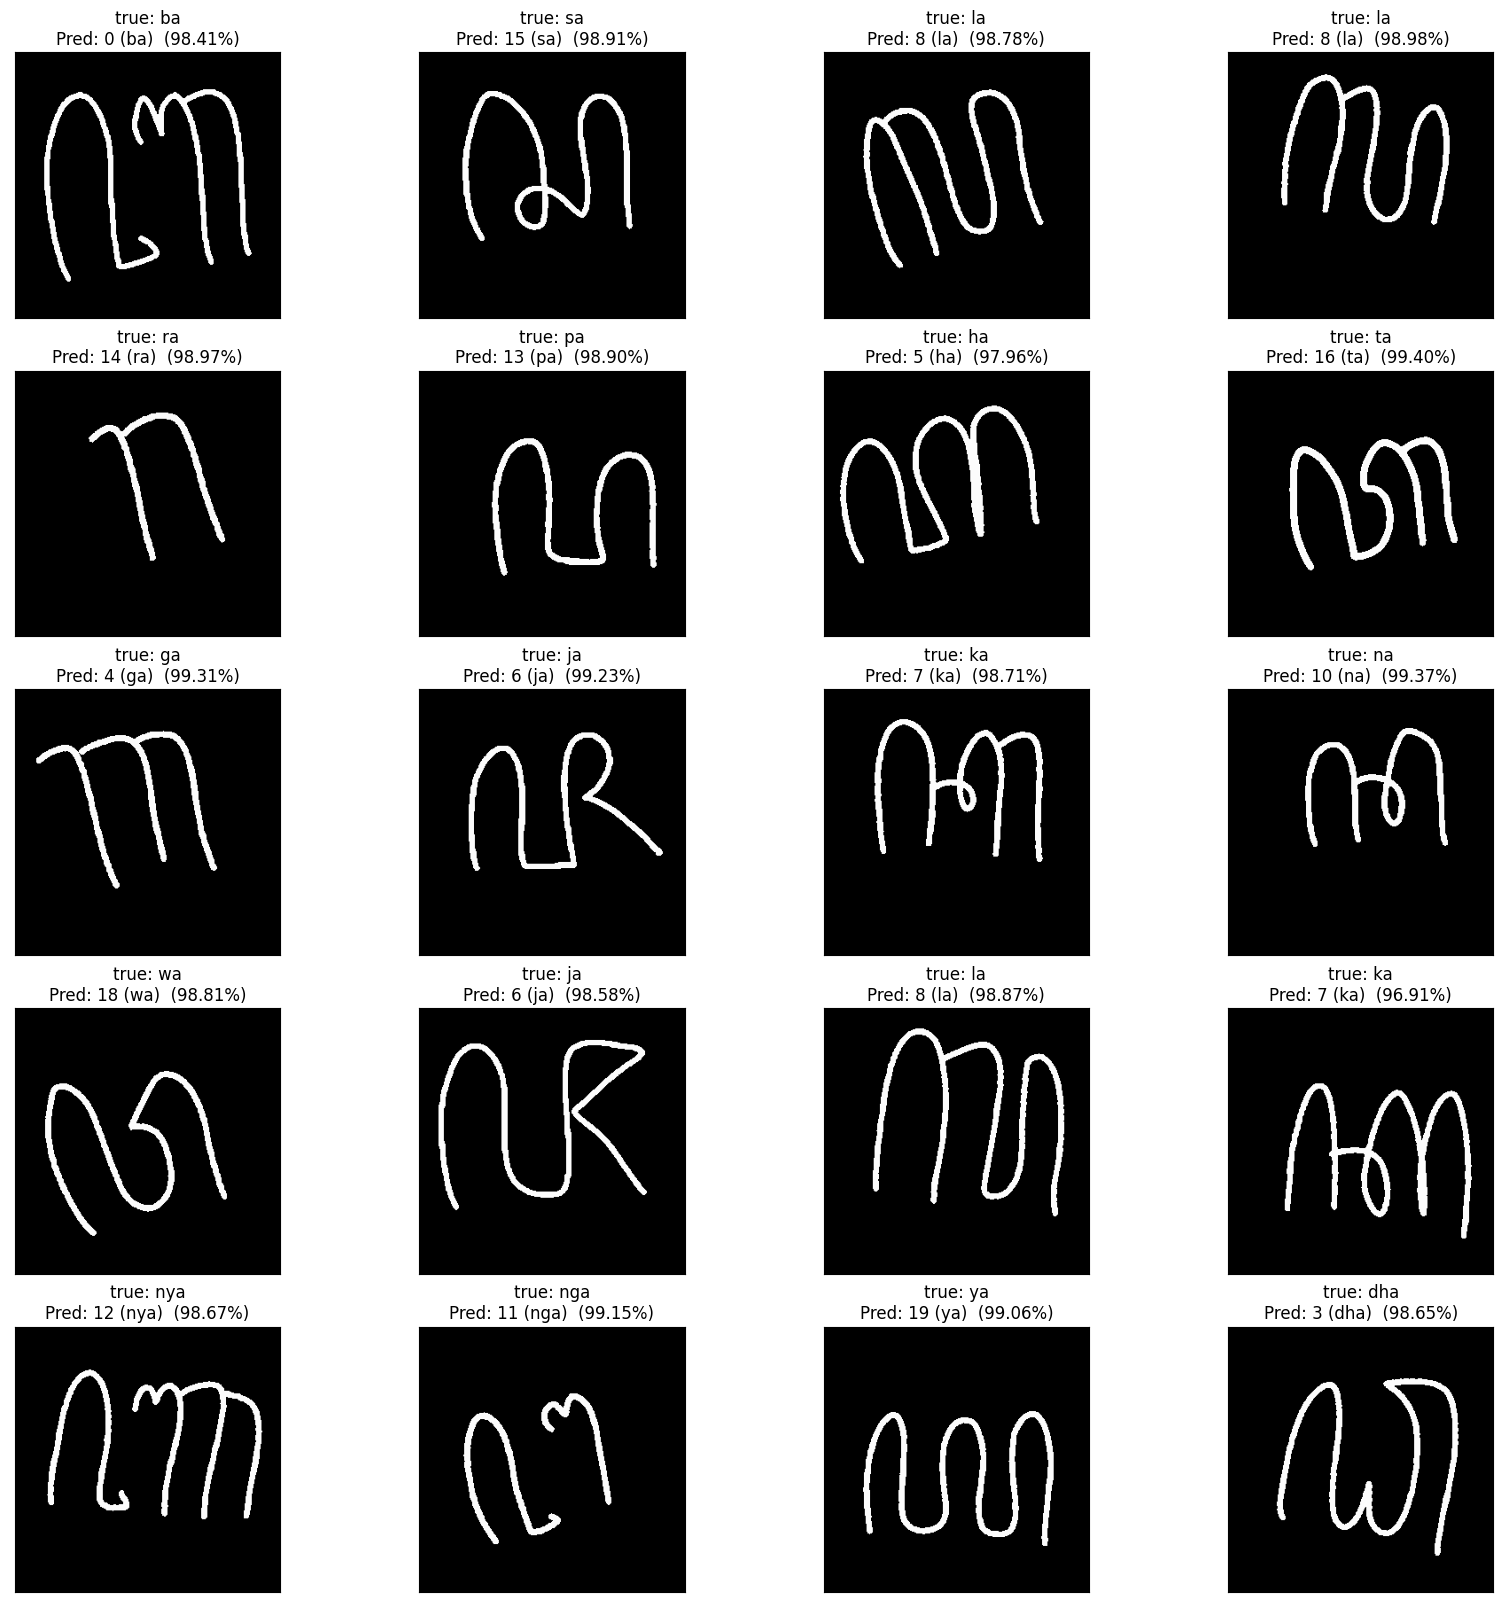

In [28]:
plot_images(test_dataset, model=xception, n_rows=5)